M25MAC008 : Problem 4: NLU Assignment

In [19]:
#importing libraries to use globaly in the program
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for visualization
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Preparing Dataset ~ using the official NewsGroups Dataset from sklearn datasets

In [20]:
from typing_extensions import Required
from sklearn.datasets import fetch_20newsgroups

# Extracting only the categories for this project.
Required_categories = [
    'rec.sport.baseball',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'rec.sport.hockey'

]

# Fetching the training data filtered by these categories
Training_data = fetch_20newsgroups(
    subset='train',
    categories=Required_categories,
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

# Fetching the testing data using the same filter
Testing_data = fetch_20newsgroups(
    subset='test',
    categories=Required_categories,
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

# Print a sample to verify
print(f"Number of documents: {len(Training_data.data)}")
print(f"Target Names: {Training_data.target_names}")

Number of documents: 2772
Target Names: ['rec.sport.baseball', 'rec.sport.hockey', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc']


In [21]:
print(Training_data)

{'data': ['\nIn billions of dollars (%GNP):\nyear  GNP    receipts     outlays       deficit     debt    unempl%  admin\n====  ====   ===========  ============  =========   ======  =======  =======\n1977  1930   355.6 (18.4) 409.2  (21.2) 53.6 (2.8)   709.1           Carter\n1978  2174   399.6 (18.4) 458.7  (21.1) 59.2 (2.7)   780.4           Carter\n1979  2444   463.3 (19.0) 503.5  (20.6) 40.2 (1.6)   833.8           Carter\n1980  2674   517.1 (19.3) 590.9  (22.1) 73.8 (2.8)   914.3   7.9     Carter\n1981  2986   599.3 (20.1) 678.2  (22.7) 78.9 (2.6)  1003.9   8.4     Reagan\n1982  3130   617.8 (19.7) 745.7  (23.8) 127.9 (4.1) 1147.0  11.0     Reagan\n1983  3325   600.6 (18.1) 808.3  (24.3) 207.8 (6.2) 1381.9  10.9     Reagan\n1984  3688   666.5 (18.1) 851.8  (23.1) 185.3 (5.0) 1576.7   8.6     Reagan\n1985  3958   734.1 (18.5) 946.3  (23.9) 212.3 (5.4) 1827.5   8.1     Reagan\n1986  4177   769.1 (18.4) 989.8  (23.7) 220.7 (5.3) 2129.5   7.9     Reagan\n1987  4442   854.1 (19.2) 1002.

In [22]:
def Preprocessing_text(text):
    """
    This functions Cleans and preprocess text data.
    I chose these preprocessing steps because:
    ~ Removing extra whitespace standardizes format for the dataset
    ~ Lowercasing ensures consistency and avoids case sensitivity issues
    ~ Removing special characters reduces noise in the text
    """
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

#FEATURE EXTRACTION
    
    Extract features from text using the following different methods.
    Parameters:
    - method: 'tfidf', 'bow', or 'ngram'
    - ngram_range: (1,1) for unigrams, (1,2) for unigrams+bigrams, etc.
    - max_features: maximum number of features to keep
    

    

In [23]:
def extracting_features(texts, method='tfidf', ngram_range=(1, 2), max_features=5000):


    if method == 'tfidf':
        # TF-IDF Vectorizer
        vectorizer = TfidfVectorizer(
            ngram_range=ngram_range,
            max_features=max_features,
            stop_words='english',
            sublinear_tf=True,  # Use 1+log(tf) for term frequency
            min_df=2,  # Ignore terms that appear in less than 2 documents
            max_df=0.95  # Ignore terms that appear in more than 95% of documents
        )
    elif method == 'bow':
        # (BOW) Bag of Words (Count Vectorizer)
        vectorizer = CountVectorizer(
            ngram_range=ngram_range,
            max_features=max_features,
            stop_words='english',
            min_df=2,
            max_df=0.95
        )
    elif method == 'ngram':
        # Character n-grams (captures word patterns)
        vectorizer = TfidfVectorizer(
            analyzer='char',
            ngram_range=(3, 5),  # Character trigrams to pentagrams
            max_features=max_features,
            min_df=2,
            max_df=0.95
        )
    else:
        raise ValueError(f"method is not known: {method}")

    features = vectorizer.fit_transform(texts)
    print(f"Feature shape: {features.shape}")
    print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

    return vectorizer, features
    ''' This functions returns ~ vectorizer: fitted vectorizer
     features: transformed feature matrix'''

#MODEL DEFINITIONS - SVM, Logistic, Naive Bayes

In [24]:
def get_models():
    """
    Returns dictionary of three ML models to compare.

    I choose these three because: They are widely used and popular classifers for text classification.
    1. SVM - Powerful for high-dimensional data, finds optimal decision boundary b/w clasees
    2. Logistic Regression - Simple, interpretable, works well with sparse data
    3. Naive Bayes - Probabilistic, handles text well, fast training

    """
    models = {
        'Logistic Regression': LogisticRegression(
            C=1.0,
            max_iter=1000,
            random_state=42,
            class_weight='balanced'  # To handle potential class imbalance
        ),

        'Naive Bayes': MultinomialNB(
            alpha=1.0  # Laplace smoothing parameter
        ),

        'SVM': LinearSVC(
            C=1.0,
            max_iter=1000,
            random_state=42,
            class_weight='balanced',
            dual=False
        )
    }

    return models

In [25]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train a single model and evaluate its performance.
    Returns dictionary of metrics.
    """
    print(f"\n--- Training {model_name} ---")

    # Train the model
    model.fit(X_train, y_train)

    # For predictions
    y_pred = model.predict(X_test)

    # Calculating metrics, using 'weighted' average for multiclass classification
    metrics = {
        'model_name': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")

    return metrics, model

def cross_validate_model(model, X, y, cv=5):
    """
    Performing 5-fold cross-validation for more robust evaluation.
    """
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Cross-validation scores: {scores}")
    print(f"Mean CV accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    return scores

#Visualization

In [26]:
def plot_confusion_matrices(results, save_path='confusion_matrices.png'):
    """
    This is a function to plot confusion matrices for all models.
    """
    # Get the target names from the training data, which represents the classes.

    class_names = Training_data.target_names # to access the actual class names

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    if len(results) == 1: # Handles case with a single model to avoid indexing error with axes
        axes = [axes]

    for idx, (model_name, metrics) in enumerate(results.items()):
        cm = metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        axes[idx].set_title(f'{model_name}\nAccuracy: {metrics["accuracy"]:.3f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        # Dynamically sets tick labels based on actual class names
        axes[idx].set_xticklabels(class_names, rotation=45, ha='right')
        axes[idx].set_yticklabels(class_names, rotation=0)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrices saved to {save_path}")

def plot_model_comparison(results, save_path='model_comparison.png'):
    """
    for creating bar chart comparing model performances.
    """
    models = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    # Prepare data
    data = {metric: [results[m][metric] for m in models] for metric in metrics}

    # Plot
    x = np.arange(len(models))
    width = 0.2
    multiplier = 0

    fig, ax = plt.subplots(figsize=(10, 6))

    for metric, values in data.items():
        offset = width * multiplier
        bars = ax.bar(x + offset, values, width, label=metric.capitalize())
        multiplier += 1

    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width)
    ax.set_xticklabels(models, rotation=45)
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1)

    # For adding value labels on bars
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.3f', fontsize=8)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Model comparison saved to {save_path}")

#Function for classifying user input texts Based on trained models

In [27]:
def interactive_prediction(models_dict, vectorizer):
    """
    This function allows user to input text and get predictions from all models.
    """
    print("\n" + "^"*100)
    print("INTERACTIVE PREDICTION OF SPORTS Vs POLITICS")
    print("Enter text to classify as Sports or Politics")
    print("Type 'quit' to exit")
    print("^"*100)

    # Getting class names from the global Training_data
    class_names = Training_data.target_names

    while True:
        print("\n" + "-"*30)
        user_text = input("Enter text: ").strip()

        if user_text.lower() == 'quit':
            break

        # Preprocess text
        cleaned_text = Preprocessing_text(user_text)

        # Transformation using fitted vectorizer
        features = vectorizer.transform([cleaned_text])

        print("\nPredictions:")
        for name, model in models_dict.items():
            pred_numeric = model.predict(features)[0]
            pred_name = class_names[pred_numeric]
            proba = None

            # Get probability if available
            if hasattr(model, 'predict_proba'):
                proba = model.predict_proba(features)[0]
                confidence = max(proba)
                print(f"  {name:20}: {pred_name.upper()} (confidence: {confidence:.3f})")
            elif hasattr(model, 'decision_function'):
                # Using decision function as confidence proxy for SVM
                decision = model.decision_function(features)[0]
                confidence = abs(decision[pred_numeric]) / (abs(decision).max() + 1e-6) # Added small epsilon to avoid div by zero
                print(f"  {name:20}: {pred_name.upper()} (confidence: {confidence:.3f})")
            else:
                print(f"  {name:20}: {pred_name.upper()}")

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
SPORTS VS POLITICS CLASSIFIER
Comparing Multiple ML Techniques
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

1. Preparing Train and Test data from 20newsgroups dataset 
Total Training Samples = 2772
Total Testing Samples= 1846
Training Class Distribution= {1: 600, 0: 597, 3: 564, 2: 546, 4: 465}
Testing Class Distribution= {1: 399, 0: 397, 3: 376, 2: 364, 4: 310}

2. PREPROCESSING TEXT
Sample of cleaned training text: in billions of dollars gnp year gnp receipts outlays deficit debt unempl admin carter carter carter ...
Sample of cleaned testing text: i dont know this specific ratio but i do have an earlier post that says a gun is times more likely t...

3. DATA SPLIT SUMMARY For Training and Testing
Training samples: 2772
Testing samples: 1846

4. EXTRACTING FEATURES
Using TF-IDF with unigrams and bigrams
Feature shape: (2772, 500

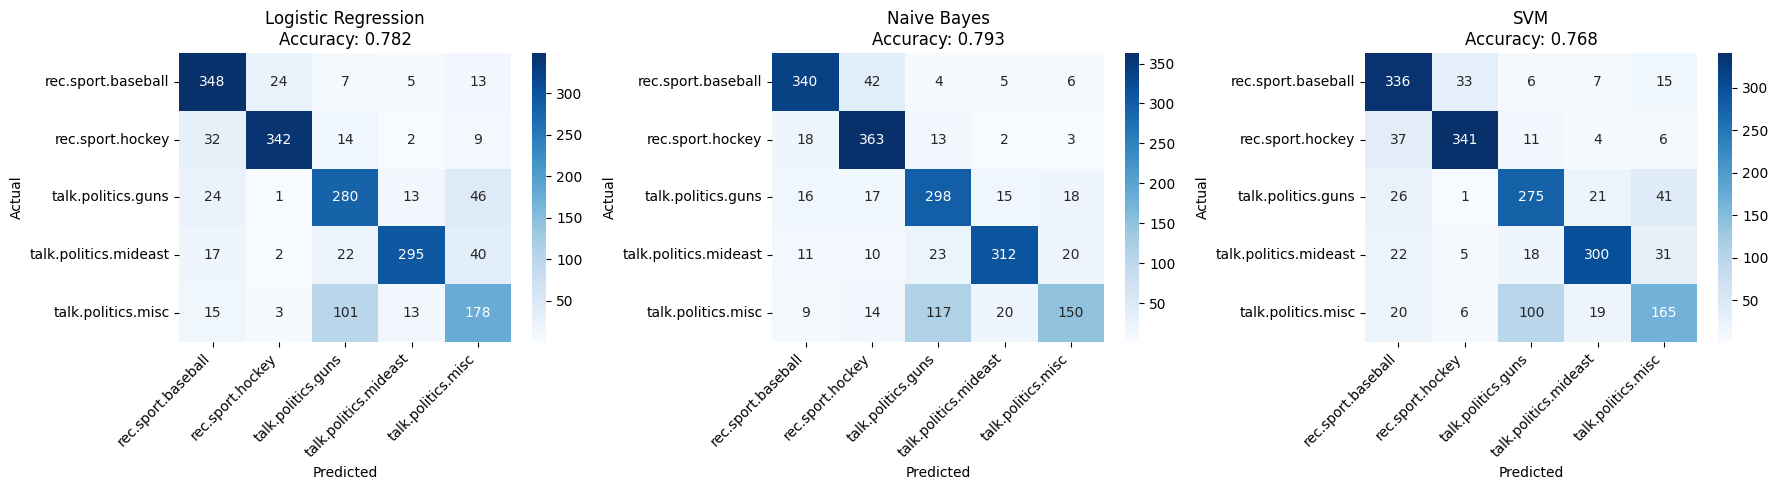

Confusion matrices saved to confusion_matrices.png


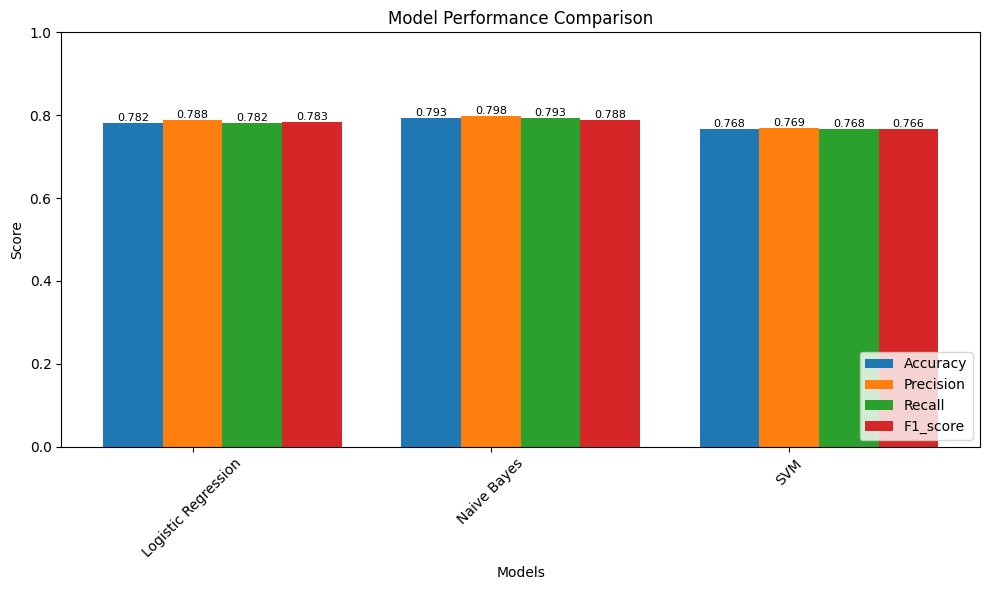

Model comparison saved to model_comparison.png

9. BEST MODEL ANALYSIS
Best model based on F1-score: Naive Bayes (0.7876)
Best model based on accuracy: Naive Bayes (0.7925)

10. INTERACTIVE PREDICTION

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
INTERACTIVE PREDICTION OF SPORTS Vs POLITICS
Enter text to classify as Sports or Politics
Type 'quit' to exit
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

------------------------------
Enter text: when is the world cup?

Predictions:
  Logistic Regression : REC.SPORT.HOCKEY (confidence: 0.498)
  Naive Bayes         : REC.SPORT.HOCKEY (confidence: 0.594)
  SVM                 : REC.SPORT.HOCKEY (confidence: 0.279)

------------------------------
Enter text: quit

11. SAVING RESULTS
Results saved to 'model_comparison_results.csv'

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PIP

In [28]:
#Main Function
def main():
    print("^"*100)
    print("SPORTS VS POLITICS CLASSIFIER")
    print("Comparing Multiple ML Techniques")
    print("^"*100)

    # Collecting and preparing data
    print("\n1. Preparing Train and Test data from 20newsgroups dataset ")
    # Training data
    X_train_raw, y_train = Training_data.data, Training_data.target
    # Testing data
    X_test_raw, y_test = Testing_data.data, Testing_data.target
    print(f"Total Training Samples = {len(X_train_raw)}")
    print(f"Total Testing Samples= {len(X_test_raw)}")
    print(f"Training Class Distribution= {pd.Series(y_train).value_counts().to_dict()}")
    print(f"Testing Class Distribution= {pd.Series(y_test).value_counts().to_dict()}")

    # Preprocessing text
    print("\n2. PREPROCESSING TEXT")
    X_train_clean = [Preprocessing_text(t) for t in X_train_raw]
    X_test_clean = [Preprocessing_text(t) for t in X_test_raw]
    print("Sample of cleaned training text:", X_train_clean[0][:100] + "...")
    print("Sample of cleaned testing text:", X_test_clean[0][:100] + "...")

    # Data split summary
    print("\n3. DATA SPLIT SUMMARY For Training and Testing")
    print(f"Training samples: {len(X_train_clean)}")
    print(f"Testing samples: {len(X_test_clean)}")

    # Extracting features using TF-IDF with n-grams
    print("\n4. EXTRACTING FEATURES")
    print("Using TF-IDF with unigrams and bigrams")
    vectorizer, X_train_features = extracting_features(
        X_train_clean,
        method='tfidf',
        ngram_range=(1, 2),  # Unigrams + bigrams
        max_features=5000
    )
    X_test_features = vectorizer.transform(X_test_clean)

    # ML models/classifiers
    print("\n5. MACHINE LEARNING MODELS")
    models = get_models()
    print(f"Models to compare: {list(models.keys())}")


    # For Training and evaluating all ml classifiers
    print("\n6. TRAINING AND EVALUATING MODELS")
    results = {}
    trained_models = {}

    for name, model in models.items():
        metrics, trained_model = train_and_evaluate_model(
            model, X_train_features, X_test_features, y_train, y_test, name
        )
        results[name] = metrics
        trained_models[name] = trained_model

        # using K-Cross-validation method for validation
        print(f"\nCross-validation for {name}:")
        cv_scores = cross_validate_model(trained_model, X_train_features, y_train)
        results[name]['cv_mean'] = cv_scores.mean()
        results[name]['cv_std'] = cv_scores.std()

    # Creating comparison tables for better summary of model performances
    print("\n7. ML MODELS PERFORMANCE COMPARISON REPORT")
    print("^"*70)
    print(f"{'Model':20} {'Accuracy':10} {'Precision':10} {'Recall':10} {'F1-Score':10} {'CV Mean':10}")
    print("^"*70)

    for name, metrics in results.items():
        print(f"{name:20} {metrics['accuracy']:.4f}     {metrics['precision']:.4f}     "
              f"{metrics['recall']:.4f}     {metrics['f1_score']:.4f}     {metrics.get('cv_mean', 0):.4f}")

    # Calling functions for visualizations
    print("\n8. GENERATING VISUALIZATIONS")
    plot_confusion_matrices(results)
    plot_model_comparison(results)

    # best model perfomance
    print("\n9. BEST MODEL ANALYSIS")
    best_model_name = max(results, key=lambda x: results[x]['f1_score'])
    best_f1 = results[best_model_name]['f1_score']
    print(f"Best model based on F1-score: {best_model_name} ({best_f1:.4f})")

    best_accuracy_model = max(results, key=lambda x: results[x]['accuracy'])
    best_acc = results[best_accuracy_model]['accuracy']
    print(f"Best model based on accuracy: {best_accuracy_model} ({best_acc:.4f})")

    # For custom inputs from the user and making interactive predictions
    print("\n10. INTERACTIVE PREDICTION")
    interactive_prediction(trained_models, vectorizer)

    # Saving the results for report
    print("\n11. SAVING RESULTS")
    results_df = pd.DataFrame(results).T
    results_df.to_csv('model_comparison_results.csv')
    print("Results saved to 'model_comparison_results.csv'")

    print("\n" + "^"*100)
    print("PIPELINE COMPLETE")
    print("^"*100)

if __name__ == "__main__":
    main()